# CMACC Insights
## Analyzing Animal Shelter Data
### Victoria Pierce Crossland


##### # About Me + Additional Context:
I am a obsessive dog mom as well as a CMACC volunteer (that happens to be extremely curious and love Python). I enjoy spending my free time walking dogs at the shelter, and sometimes even convincing my husband to let me bring one home to foster. My goals from this project are to gather data from the shelter website (scraping daily to create a df of dogs coming in and out) and to dive into trends and insights.

### CMACC Website Scraping

#### Initial Scrape

In [1]:
# Set execute_scraping to False for quick rendering, True to run scraping
execute_scraping = False
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import datetime
import os

def fetch_and_parse(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        return BeautifulSoup(response.text, 'html.parser')
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except requests.exceptions.RequestException as req_err:
        print(f"Request error occurred: {req_err}")
    return None

def extract_data(soup):
    if soup is None:
        return []
    dogs = soup.find_all('div', class_='gridResult')
    dog_list = []
    for dog in dogs:
        try:
            dog_list.append({
                'Name': dog.find('span', class_='text_Name results').text.strip() if dog.find('span', class_='text_Name results') else 'N/A',
                'Gender': dog.find('span', class_='text_Gender results').text.strip() if dog.find('span', class_='text_Gender results') else 'N/A',
                'Breed': dog.find('span', class_='text_Breed results').text.strip() if dog.find('span', class_='text_Breed results') else 'N/A',
                'Age': dog.find('span', class_='text_Age results').text.strip() if dog.find('span', class_='text_Age results') else 'N/A',
                'Animal Type': dog.find('span', class_='text_Animaltype results').text.strip() if dog.find('span', class_='text_Animaltype results') else 'N/A',
                'Weight': dog.find('span', class_='text_Weight results').text.strip() if dog.find('span', class_='text_Weight results') else 'N/A',
                'Brought to Shelter': dog.find('span', class_='text_Broughttotheshelter results').text.strip() if dog.find('span', class_='text_Broughttotheshelter results') else 'N/A',
                'Located At': dog.find('span', class_='text_Locatedat results').text.strip() if dog.find('span', class_='text_Locatedat results') else 'N/A',
                'Kennel Location': dog.find('span', class_='text_KennelLocation results').text.strip() if dog.find('span', class_='text_KennelLocation results') else 'N/A',
                'Qualified For': dog.find('span', class_='text_ViewType results').text.strip() if dog.find('span', class_='text_ViewType results') else 'N/A'
            })
        except AttributeError as e:
            print(f"Error extracting data for one dog: {e}")
    return dog_list

def scrape_dog_data():
    base_url = 'https://24petconnect.com/CLTAdopt'
    index = 0
    all_dogs = []
    current_date = datetime.datetime.now().strftime('%Y-%m-%d')

    while True:
        current_url = f"{base_url}?index={index}&at=DOG"
        print(f"[{datetime.datetime.now()}] Fetching data from index: {index}")
        soup = fetch_and_parse(current_url)
        new_dogs = extract_data(soup)
        if not new_dogs:  # If no dogs found, assume end of data
            print("No more dogs found. Exiting loop.")
            break
        all_dogs.extend(new_dogs)
        index += 30
        time.sleep(1)

    print(f"Total dogs fetched: {len(all_dogs)}")
    dogs_at_shelter = pd.DataFrame(all_dogs)
    dogs_at_shelter['Scrape Date'] = current_date


    csv_file = 'dogs_at_shelter.csv'
    if os.path.exists(csv_file):
        existing_data = pd.read_csv(csv_file)
        updated_data = pd.concat([existing_data, dogs_at_shelter], ignore_index=True)
        updated_data.to_csv(csv_file, index=False)
        print(f"[{datetime.datetime.now()}] Data appended to '{csv_file}'.")
    else:
        dogs_at_shelter.to_csv(csv_file, index=False)
        print(f"[{datetime.datetime.now()}] Data saved to '{csv_file}'.")

if execute_scraping:
    scrape_dog_data()







### Schedule Daily Scrape: I want to collect this data daily in order to be able to assess what dogs are coming in and out. I will perform the schedule in another doc and read in the data here. Check out my GitHub to see my script to schedule the scrape!


In [2]:
#View Inital Data

dogs_at_shelter = pd.read_csv('dogs_at_shelter.csv')

dogs_at_shelter = dogs_at_shelter.drop_duplicates()

dogs_at_shelter.head()



,Name,Gender,Breed,Age,Animal Type,Weight,Brought to Shelter,Located At,Kennel Location,Qualified For,Scrape Date
0,CAROLINA (A1180514),Female,English Foxhound,4 years old,Dog,62 pounds,2024.12.08,Charlotte-Mecklenburg Animal Services,TOOMEYD21,adopt,2024-12-08
1,COSMO (A1221785),Male,Pit Bull Terrier,"1 year, 9 months old",Dog,46 pounds,2024.12.08,Charlotte-Mecklenburg Animal Services,TOOMEYD12,adopt,2024-12-08
2,TOKYO (A1225928),Female,Plott Hound mix,"1 year, 1 month old",Dog,54 pounds,2024.12.08,Charlotte-Mecklenburg Animal Services,TOOMEYD33,adopt,2024-12-08
3,TANDY (A1232250),Male,Labrador Retriever mix,"1 year, 4 months old",Dog,66 pounds,2024.12.08,Charlotte-Mecklenburg Animal Services,TOOMEYD08,adopt,2024-12-08
4,REBEL (A1235595),Male,Labrador Retriever mix,5 years old,Dog,50 pounds,2024.12.08,Charlotte-Mecklenburg Animal Services,TOOMEYD24,adopt,2024-12-08


## Data Wrangling

In [3]:
# Age is in months and years. Create a numeric variable.

def convert_age_to_years(age):
    if pd.isnull(age):  # Check if the age is NaN
        return None
    if isinstance(age, str):  # Ensure that the age is a string
        if 'year' in age:
            return int(age.split()[0])  # Extract the number of years
        elif 'month' in age:
            return int(age.split()[0]) / 12  # Convert months to years
        elif 'weeks' in age:
            return int(age.split()[0]) / 52
    return None  # Return None if age is not a string or doesn't contain 'year' or 'month'


# Apply the updated function
dogs_at_shelter['age_numeric'] = dogs_at_shelter['Age'].apply(convert_age_to_years)

# Let's get Weight as a numeric variable!
dogs_at_shelter['Weight_num'] = dogs_at_shelter['Weight'].str.extract(r'(\d+\.?\d*)').astype(float)


# Rename Name column & separate into 'name' and 'id' columns
dogs_at_shelter.rename(columns={'Name': 'Name_ID'}, inplace=True)
# Splitting the 'Name_ID' column into 'Name' and the ID part
dogs_at_shelter['Name'] = dogs_at_shelter['Name_ID'].str.extract(r'([A-Za-z\s]+) \(')  # Extracts only the name part before the space and parenthesis
dogs_at_shelter['ID'] = dogs_at_shelter['Name_ID'].str.extract(r'(\d+)')  # Extracts only the numeric part

dogs_at_shelter.head()


,Name_ID,Gender,Breed,Age,Animal Type,Weight,Brought to Shelter,Located At,Kennel Location,Qualified For,Scrape Date,age_numeric,Weight_num,Name,ID
0,CAROLINA (A1180514),Female,English Foxhound,4 years old,Dog,62 pounds,2024.12.08,Charlotte-Mecklenburg Animal Services,TOOMEYD21,adopt,2024-12-08,4.0,62.0,CAROLINA,1180514
1,COSMO (A1221785),Male,Pit Bull Terrier,"1 year, 9 months old",Dog,46 pounds,2024.12.08,Charlotte-Mecklenburg Animal Services,TOOMEYD12,adopt,2024-12-08,1.0,46.0,COSMO,1221785
2,TOKYO (A1225928),Female,Plott Hound mix,"1 year, 1 month old",Dog,54 pounds,2024.12.08,Charlotte-Mecklenburg Animal Services,TOOMEYD33,adopt,2024-12-08,1.0,54.0,TOKYO,1225928
3,TANDY (A1232250),Male,Labrador Retriever mix,"1 year, 4 months old",Dog,66 pounds,2024.12.08,Charlotte-Mecklenburg Animal Services,TOOMEYD08,adopt,2024-12-08,1.0,66.0,TANDY,1232250
4,REBEL (A1235595),Male,Labrador Retriever mix,5 years old,Dog,50 pounds,2024.12.08,Charlotte-Mecklenburg Animal Services,TOOMEYD24,adopt,2024-12-08,5.0,50.0,REBEL,1235595



##### CMACC context: As a CMACC Volunteer, I have the inside scoop on what the locations mean. I know the DoginCare Unit is at the larger Byrum location, as well as the ADPTPUP (puppy kennels) and LST units (dogs found as a stray & on a 3 day hold so owners have a chance to reclaim). The Toomey location is the satellite location. I also want to seperate out the Kennel Location vs Kennel Number. Kennel Name corresponds to what hallway the dog is located on, while the Kennel Number is the refers to the location on the hallway. Kennels are numbered in ascending order. The Byrum location has a hallway with dogs on both sides, so I am also creating a variable that grabs the side of the kennel location.

In [4]:
# Create new variables that simplifies and splits out location.
import numpy as np

dogs_at_shelter['location_simple'] = np.where(
    dogs_at_shelter['Kennel Location'].str.contains('toom', case=False, na=False), 'Toomey',
    np.where(
        dogs_at_shelter['Kennel Location'].str.contains('CARE|LST|ADOPT|PUPPY|INTAKE|CLINIC|FOUND|FERRET|ADPT', case=False), 'Byrum',
    np.where(
        dogs_at_shelter['Kennel Location'].str.contains('Foster', case=False), 'Foster',
         dogs_at_shelter['Kennel Location'])))


dogs_at_shelter['kennel_name'] = dogs_at_shelter['Kennel Location'].str.extract(r'([A-Za-z\s]+)')  # Extracts name/hallyway location
dogs_at_shelter['kennel_num'] = dogs_at_shelter['Kennel Location'].str.extract(r'(\d+)')  # Extracts number
dogs_at_shelter['side'] = dogs_at_shelter['Kennel Location'].apply(
    lambda x: '' if 'FOSTER' in x or x[-1] not in ['R', 'L'] else x[-1])





# Create variable to count how long a dog has been in the shelter
dogs_at_shelter['Brought to Shelter'] = pd.to_datetime(dogs_at_shelter['Brought to Shelter'])
dogs_at_shelter['Scrape Date'] = pd.to_datetime(dogs_at_shelter['Scrape Date'])
dogs_at_shelter['Days_at_shelter'] = (dogs_at_shelter['Scrape Date'] - dogs_at_shelter['Brought to Shelter']).dt.days
dogs_at_shelter.head()


# Drop columns not needed
dogs_at_shelter = dogs_at_shelter.drop(columns=['Qualified For', 'Located At'])

## Top Level Highlights for Today

In [5]:

from datetime import datetime

# Today's date and current data filtering
today_date = datetime.today().strftime('%Y-%m-%d')
current_dogs = dogs_at_shelter[dogs_at_shelter['Scrape Date'] == today_date]

if current_dogs.empty:
    max_date = dogs_at_shelter['Scrape Date'].max()
    current_dogs = dogs_at_shelter[dogs_at_shelter['Scrape Date'] == max_date]


max_date = current_dogs['Scrape Date'].max()
gender_counts = current_dogs['Gender'].value_counts()
female_count = gender_counts.get('Female', 0)
male_count = gender_counts.get('Male', 0)
percent_male = male_count / (male_count + female_count)

# Smallest and largest dogs
smallest_dog = current_dogs['Weight_num'].min()
largest_dog = current_dogs['Weight_num'].max()

# Top breeds
filtered_breeds = current_dogs[current_dogs['Breed'] != 'Breed information is not provided by this shelter']
breed_counts = filtered_breeds['Breed'].value_counts().head(5)

# Location counts
location_counts = current_dogs['location_simple'].value_counts()

# Sick dogs
count_sick = current_dogs['Kennel Location'].str.contains('CARE').sum()

# Longest stay dogs
dogs_located_at_shelter = current_dogs[current_dogs['Kennel Location'].str.contains('CARE|LST|ADOPT|TOOM')]
max_days_in_shelter = dogs_located_at_shelter['Days_at_shelter'].max()
longest_stay_dogs = dogs_located_at_shelter[dogs_located_at_shelter['Days_at_shelter'] == max_days_in_shelter]

# Final output as a multi-line formatted string
output = f"""
### CMACC Highlights: {max_date.strftime('%Y-%m-%d')}

**Number of females:** {female_count}
**Number of males:** {male_count}
**{percent_male:.2%}** of dogs currently at the shelter are male.

**Smallest Dog:** {smallest_dog} pounds
**Largest Dog:** {largest_dog} pounds

**The 5 most found breeds currently at the shelter are:**
- {breed_counts.index[0]}: {breed_counts.iloc[0]}
- {breed_counts.index[1]}: {breed_counts.iloc[1]}
- {breed_counts.index[2]}: {breed_counts.iloc[2]}
- {breed_counts.index[3]}: {breed_counts.iloc[3]}
- {breed_counts.index[4]}: {breed_counts.iloc[4]}

**Number of dogs by location:**
- **Foster:** {location_counts.get('Foster', 0)}
- **Byrum:** {location_counts.get('Byrum', 0)}
- **Toomey:** {location_counts.get('Toomey', 0)}

**There are {count_sick} sick dogs** in the Dogs In Care unit at Byrum.

**The dog(s) with the longest stay:**
- {', '.join(longest_stay_dogs['Name'].tolist())} has been at the shelter the longest at **{max_days_in_shelter} days**.
"""

# Write the output as raw Markdown
from IPython.display import display, Markdown
display(Markdown(output))

### Final DF

dogs_at_shelter.sample(10)


### CMACC Highlights: 2025-01-09

**Number of females:** 130
**Number of males:** 182
**58.33%** of dogs currently at the shelter are male.

**Smallest Dog:** 7.0 pounds
**Largest Dog:** 120.0 pounds

**The 5 most found breeds currently at the shelter are:**
- Pit Bull Terrier: 120
- Pit Bull Terrier mix: 33
- Labrador Retriever: 13
- Labrador Retriever mix: 13
- German Shepherd Dog: 11

**Number of dogs by location:**
- **Foster:** 222
- **Byrum:** 69
- **Toomey:** 21

**There are 8 sick dogs** in the Dogs In Care unit at Byrum.

**The dog(s) with the longest stay:**
- RILEY has been at the shelter the longest at **47 days**.


,Name_ID,Gender,Breed,Age,Animal Type,Weight,Brought to Shelter,Kennel Location,Scrape Date,age_numeric,Weight_num,Name,ID,location_simple,kennel_name,kennel_num,side,Days_at_shelter
29199,MUGSY (A1237801),Male,Pit Bull Terrier,4 years old,Dog,56 pounds,2024-12-19,DOGNCARE 2,2025-01-04,4.000000,56.0,MUGSY,1237801,Byrum,DOGNCARE,2,,16
26472,LOKI (A1235021),Male,Breed information is not provided by this shelter,"2 years, 3 months old",Dog,70 pounds,2024-12-08,FOSTER,2025-01-02,2.000000,70.0,LOKI,1235021,Foster,FOSTER,NaN,,25
15601,VIOLET (A1228132),Female,Pit Bull Terrier,6 years old,Dog,60 pounds,2024-11-17,FOSTER,2024-12-24,6.000000,60.0,VIOLET,1228132,Foster,FOSTER,NaN,,37
6454,HAZEL (A1236066),Female,Pit Bull Terrier,3 years old,Dog,40 pounds,2024-12-04,FOSTER,2024-12-16,3.000000,40.0,HAZEL,1236066,Foster,FOSTER,NaN,,12
10400,RAYNE (A1217502),Female,Pit Bull Terrier,"2 years, 3 months old",Dog,63 pounds,2024-08-09,FOSTER,2024-12-20,2.000000,63.0,RAYNE,1217502,Foster,FOSTER,NaN,,133
9098,QUEEN (A1238696),Female,Staffordshire Bull Terrier mix,"2 years, 10 months old",Dog,30 pounds,2025-01-07,LST 17R,2025-01-09,2.000000,30.0,QUEEN,1238696,Byrum,LST,17,R,2
22333,HANK (A1238030),Male,Labrador Retriever,10 months old,Dog,17 pounds,2024-12-21,FOSTER,2024-12-30,0.833333,17.0,HANK,1238030,Foster,FOSTER,NaN,,9
200,GRANT (A1236197),Male,German Shepherd Dog,"1 year, 1 month old",Dog,63 pounds,2024-11-07,ADOPT 20R,2024-12-08,1.000000,63.0,GRANT,1236197,Byrum,ADOPT,20,R,31
19727,A1237924,Male,Pit Bull Terrier,4 years old,Dog,58 pounds,2024-12-21,ADOPT 07L,2024-12-28,4.000000,58.0,NaN,1237924,Byrum,ADOPT,07,L,7
1140,LOUIE (A1237152),Male,American Bully,2 years,Dog,63 pounds,2024-12-02,LST 08R,2024-12-11,2.000000,63.0,LOUIE,1237152,Byrum,LST,08,R,9



## EDA


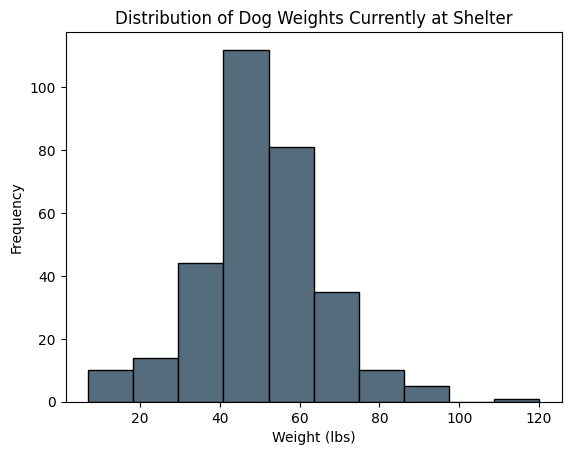

<Figure size 800x400 with 0 Axes>

In [6]:

import matplotlib.pyplot as plt

# Histogram of dog weights

current_dogs['Weight_num'].plot(kind='hist', bins=10, edgecolor='black', color= '#556C7C')
plt.title('Distribution of Dog Weights Currently at Shelter')
plt.xlabel('Weight (lbs)')
plt.ylabel('Frequency')
plt.figure(figsize=(8, 4))
plt.tight_layout()
plt.show()

In [7]:
##### Generally an even weight distribution

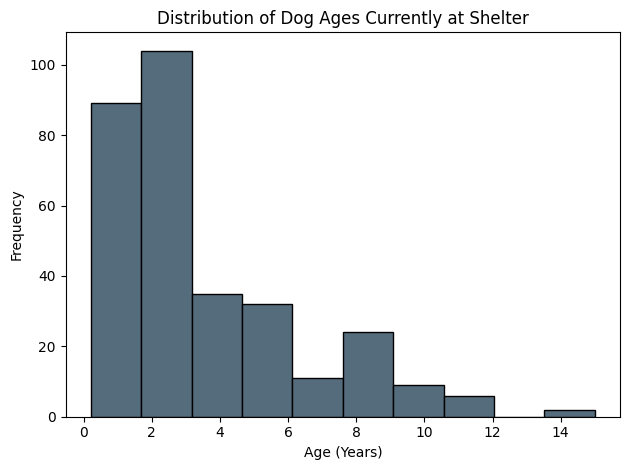

<Figure size 800x400 with 0 Axes>

In [8]:
# Histogram of dog ages

current_dogs['age_numeric'].plot(kind='hist', bins=10, edgecolor='black', color= '#556C7C')
plt.title('Distribution of Dog Ages Currently at Shelter')
plt.xlabel('Age (Years)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.figure(figsize=(8, 4))
plt.show()

##### Generally right skewed: Many more young dogs compared to older.

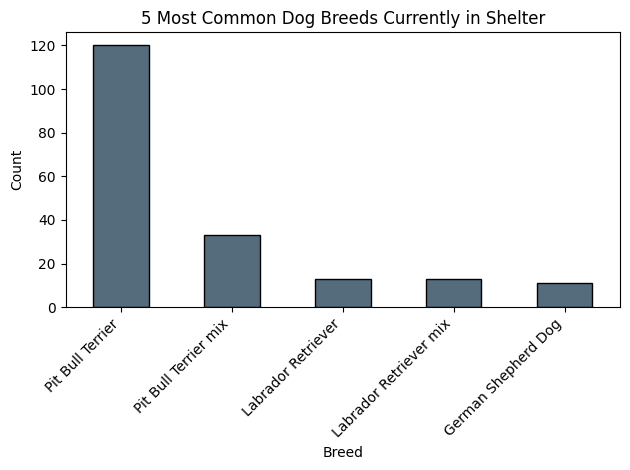

<Figure size 800x400 with 0 Axes>

In [9]:
# Plot 1: Bar chart: count of dogs by breed - top 5
breed_counts.plot(kind='bar', edgecolor='black', color= '#556C7C')
plt.title('5 Most Common Dog Breeds Currently in Shelter')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.figure(figsize=(8, 4))
plt.show()


###### We generally see a large majority of pitties and pit mixes

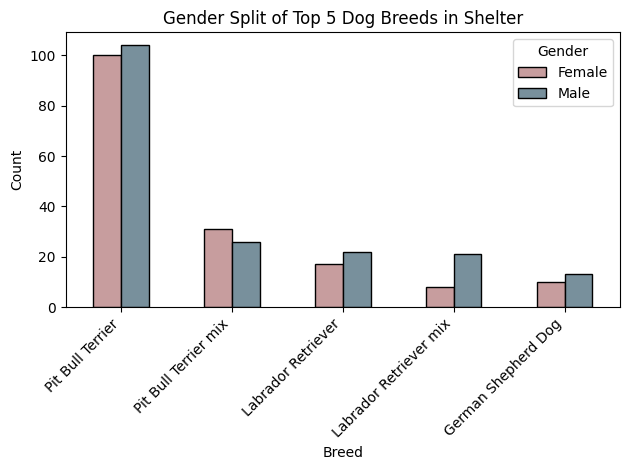

In [10]:
# Female vs male for most popular shelter breeds
top_breeds = breed_counts.index.tolist()  # Extract breed names for the top breeds

# Keep only the latest record for each unique 'ID' to avoid duplicates
unique_dogs = dogs_at_shelter.sort_values('Scrape Date').drop_duplicates(subset='ID', keep='last')

filtered_counts = unique_dogs[unique_dogs['Breed'].isin(top_breeds)]
gender_counts = filtered_counts.groupby(['Breed', 'Gender']).size().unstack(fill_value=0)

# Ordering
gender_counts['Total'] = gender_counts.sum(axis=1)
gender_counts = gender_counts.sort_values(by='Total', ascending=False).drop(columns=['Total'])


# Plotting the data
ax = gender_counts.plot(kind='bar', color={'Male': '#78909C', 'Female': '#C79D9E'}, edgecolor='black')
plt.title('Gender Split of Top 5 Dog Breeds in Shelter')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

##### More males than females typically


## Shelter Capacity Concerns

#### CMACC Shelter Contxt:  Unfortunately, the number of dogs in need of homes is not only outpacing the public's adoption rate - The number of dogs that are abandoned at the shelter is also surpassing the shelter's maximum capacity. When the shelter is over capacity, a plea goes out to volunteers and fosters to open up their homes, spread the word, and ultimately save CMACC from making heartbreaking decisions.


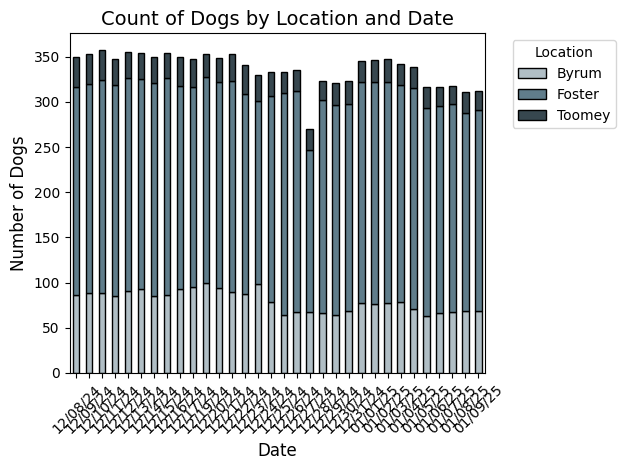

In [11]:

dogs_at_shelter['Scrape Date'] = pd.to_datetime(dogs_at_shelter['Scrape Date'], format='%m/%d/%Y')

# Grouping by Date and Location and counting the number of dogs
dogs_grouped = dogs_at_shelter.groupby(['Scrape Date', 'location_simple']).size().unstack(fill_value=0)
dogs_grouped.sort_index(inplace=True)
dogs_grouped.index = dogs_grouped.index.strftime('%m/%d/%y')

# Plotting all CMACC Dogs
dogs_grouped.plot(kind='bar', stacked=True, edgecolor='black', color=['#B0BEC5', '#607D8B', '#37474F'])
plt.title('Count of Dogs by Location and Date', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Dogs', fontsize=12)
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

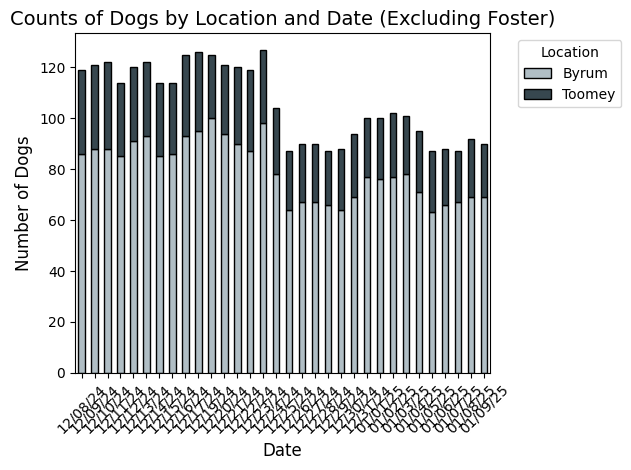

In [12]:

# Filtering out 'Foster' for capacity concerns
at_shelter = dogs_at_shelter[dogs_at_shelter['location_simple'] != 'Foster']
dogs_grouped = at_shelter.groupby(['Scrape Date', 'location_simple']).size().unstack(fill_value=0)
dogs_grouped.sort_index(inplace=True)
dogs_grouped.index = dogs_grouped.index.strftime('%m/%d/%y')

# Plotting the second chart without 'Foster'
dogs_grouped.plot(kind='bar', stacked=True, color=['#B0BEC5', '#37474F'], edgecolor='black')
plt.title('Counts of Dogs by Location and Date (Excluding Foster)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Dogs', fontsize=12)
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Send Myself A Warning Email if Capacity Gets Tight
#### Currenly, the Foster Coordinator sends out a plea to volunteers when the shelter is over capacity. Let's automate that.

In [13]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from safepw import password



# When space gets tight, they are able to transport dogs between the Byrum and Toomey locations, so I will be looking at the total between the two for capacity.
dogs_grouped['Total'] = dogs_grouped['Byrum'] + dogs_grouped['Toomey']
dogs_grouped.head()

# Check the latest date's total
latest_total = dogs_grouped.iloc[-1]['Total']
def send_email_if_necessary():
    if latest_total > 130:
        # Email details
        sender_email = "vicpierce101@gmail.com"
        receiver_email = "vicpierce101@gmail.com"
        password = my_password  #Password in a secure space

        # Set up the MIME
        message = MIMEMultipart()
        message['From'] = sender_email
        message['To'] = receiver_email
        message['Subject'] = 'Alert: High Dog Total at Shelter'

        body = f"The total count of dogs on the latest scrape date is {latest_total}, which is above max capacity. Beg your husband to go grab another foster."
        message.attach(MIMEText(body, 'plain'))

        # SMTP session
        try:
            server = smtplib.SMTP('smtp.gmail.com', 587)

            server.starttls()
            server.login(sender_email, password)
            text = message.as_string()
            server.sendmail(sender_email, receiver_email, text)
            server.quit()
            print("Email sent successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print("Total is not greater than 130, no email sent.")


send_email_if_necessary()

Total is not greater than 130, no email sent.


In [14]:
# Convert Scrape Date to datetime once, outside the function
dogs_at_shelter['Scrape Date'] = pd.to_datetime(dogs_at_shelter['Scrape Date'])

# Calculate the most recent date only once
most_recent_date = dogs_at_shelter['Scrape Date'].max()

def assign_result(row):
    current_date = row['Scrape Date']
    dog_id = row['ID']

    # Use logical indexing to find if there are any future dates for the same ID
    is_in_next = (dogs_at_shelter[(dogs_at_shelter['Scrape Date'] > current_date) & 
                                  (dogs_at_shelter['ID'] == dog_id)].shape[0] > 0)

    if current_date == most_recent_date:
        return "Looking for Furever Home"
    elif not is_in_next:
        return "Adopted"
    else:
        return "Looking for Furever Home"

# Apply the function to the DataFrame
dogs_at_shelter['result'] = dogs_at_shelter.apply(assign_result, axis=1)


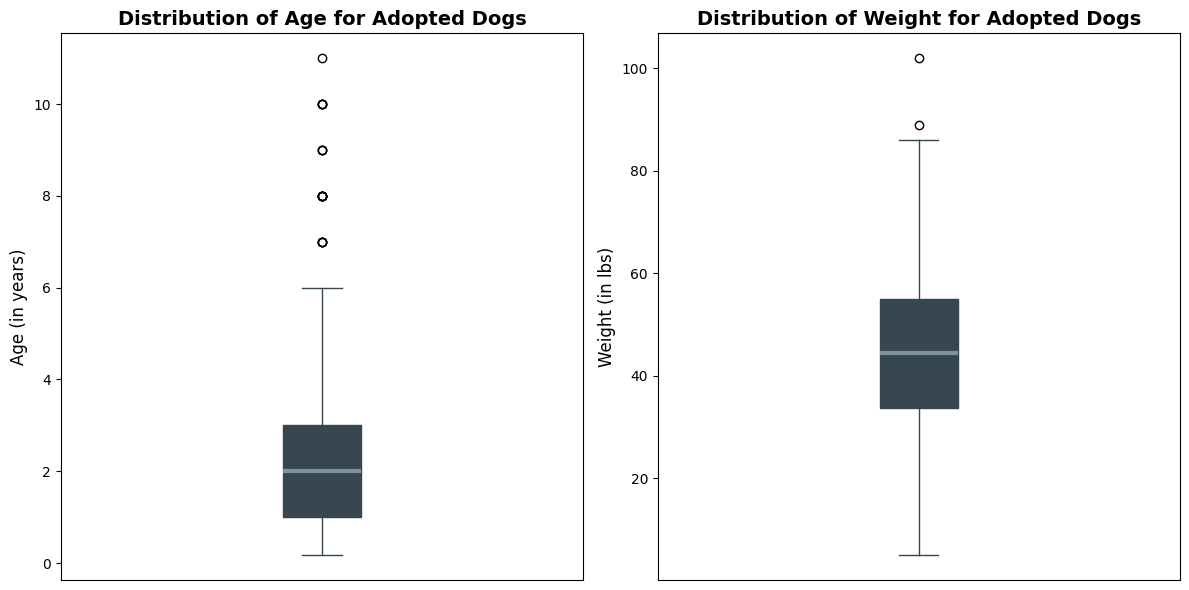

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming dogs_at_shelter is already loaded and contains 'result', 'age_numeric', and 'Weight_num' columns
adopted_dogs = dogs_at_shelter[dogs_at_shelter['result'] == 'Adopted']
adopted_dogs = adopted_dogs.dropna(subset=['age_numeric', 'Weight_num'])

# Calculate medians
median_age = adopted_dogs['age_numeric'].median()
median_weight = adopted_dogs['Weight_num'].median()

# Styling the boxplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')  # Properly unpack fig and axes
plt.subplots_adjust(wspace=.3)  # Add more space between the two plots

box_color = '#37474F'

# Age Boxplot
boxes_age = axes[0].boxplot(
    adopted_dogs['age_numeric'],
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor=box_color, color=box_color),
    whiskerprops=dict(color=box_color),
    capprops=dict(color=box_color),
    medianprops=dict(color='#7C959C', linewidth=3)
)
axes[0].set_title('Distribution of Age for Adopted Dogs', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Age (in years)', fontsize=12)
axes[0].set_xticks([])  # Remove x-axis tick '1'

# Weight Boxplot
boxes_weight = axes[1].boxplot(
    adopted_dogs['Weight_num'],
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor=box_color, color=box_color),
    whiskerprops=dict(color=box_color),
    capprops=dict(color=box_color),
    medianprops=dict(color='#7C959C', linewidth=3)
)
axes[1].set_title('Distribution of Weight for Adopted Dogs', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Weight (in lbs)', fontsize=12)
axes[1].set_xticks([])  # Remove x-axis tick '1'

plt.tight_layout()  # Adjust the layout to make room for plot elements
plt.show()  # Show the plot at the end after all customizations



##### This reflects what I would expect. The spread of weights and ages of adopted dogs is similar to the spreads of the general shelter population.

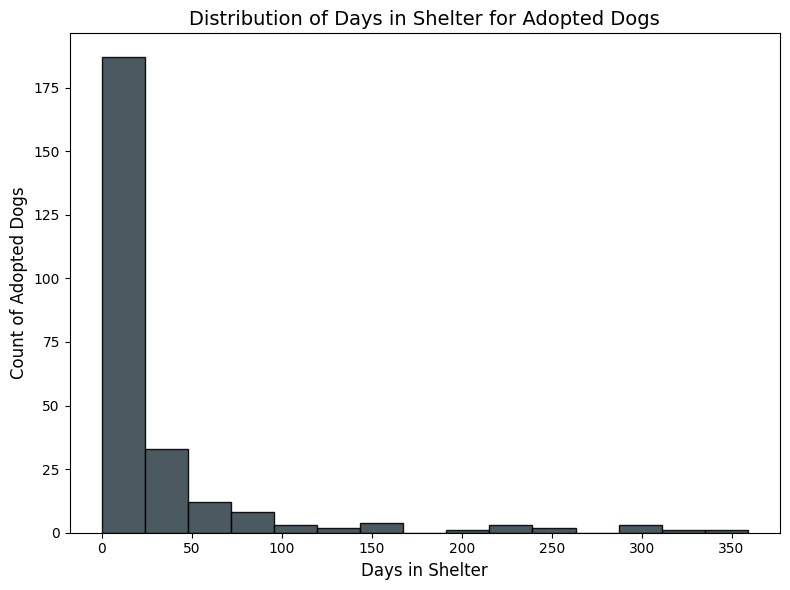

In [16]:
# Distribution of Days in Shelter for Adopted Dogs

# Ensure 'Days_at_shelter' is numeric
adopted_dogs['Days_at_shelter'] = pd.to_numeric(adopted_dogs['Days_at_shelter'], errors='coerce')
adopted_dogs.dropna(subset=['Days_at_shelter'], inplace=True)

# Set up the plot
plt.figure(figsize=(8, 6))  # Define a single figure with size

# Create a histogram
plt.hist(adopted_dogs['Days_at_shelter'], bins=15, color='#37474F', edgecolor='black', alpha=0.9)

# Add title and labels
plt.title('Distribution of Days in Shelter for Adopted Dogs', fontsize=14)
plt.xlabel('Days in Shelter', fontsize=12)
plt.ylabel('Count of Adopted Dogs', fontsize=12)

# Customize ticks
plt.xticks(rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()


##### The vast majority of dogs find their forever homes in hunder a month!

##### Disclaimer: Data is still very small - this is the breakout for adoptions in less than a month.

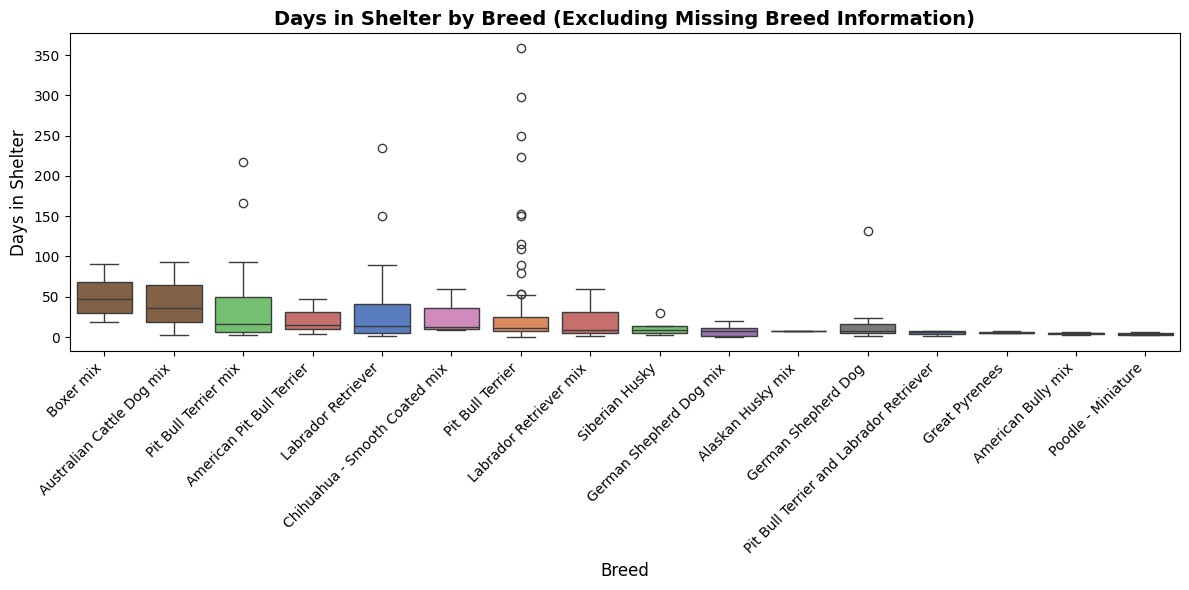

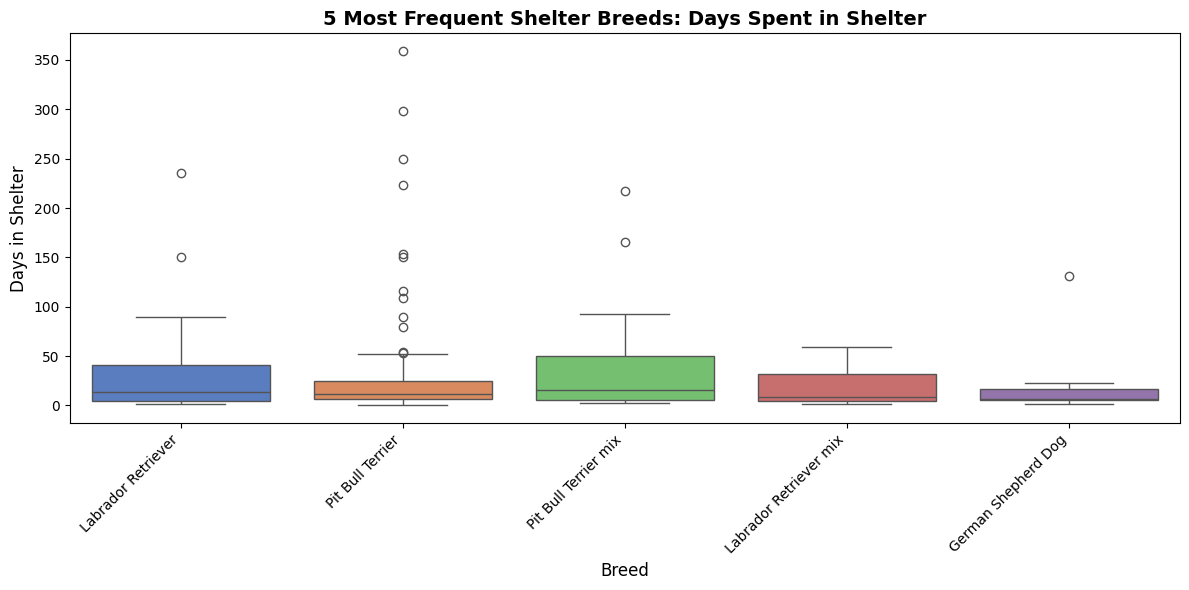

In [17]:
# Days in Shelter by Breed Boxplot

# Exclude 'Breed information is not provided by this shelter'
filtered_dogs = adopted_dogs[
    (adopted_dogs['Breed'] != 'Breed information is not provided by this shelter') &
    (adopted_dogs.groupby('Breed')['Breed'].transform('count') >= 3)
]


# Calculate median Days_at_shelter for each Breed and sort
breed_order = (
    filtered_dogs.groupby('Breed')['Days_at_shelter']
    .median()
    .sort_values(ascending=False)
    .index)

# Boxplot with all breeds ordered by median Days_at_shelter
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Breed',
    y='Days_at_shelter',
    data=filtered_dogs,
    order=breed_order,  # Order breeds by median Days_at_shelter
    hue = 'Breed',
    palette='muted')

plt.title('Days in Shelter by Breed (Excluding Missing Breed Information)', fontsize=14, fontweight='bold')
plt.xlabel('Breed', fontsize=12)
plt.ylabel('Days in Shelter', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()
plt.show()

# Calculate the top 5 breeds excluding missing breed information
top_breeds = (
    filtered_dogs['Breed']
    .value_counts()
    .head(5)
    .index
)

# Filter the data for the top 5 breeds
filtered_top_breeds = filtered_dogs[filtered_dogs['Breed'].isin(top_breeds)]

# Boxplot for the top 5 breeds
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Breed',
    y='Days_at_shelter',
    data=filtered_top_breeds,
    hue='Breed',
    palette='muted'
)
plt.title('5 Most Frequent Shelter Breeds: Days Spent in Shelter', fontsize=14, fontweight='bold')
plt.xlabel('Breed', fontsize=12)
plt.ylabel('Days in Shelter', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


##### Again, this will be more interesting once I have more data - Stay tuned! But as I have seen as a volunteer- pitties, german shephards, and huskys are typically overlooked (or not adopted due to breed restrictions) while more sought after "designer" breeds are adopted quickly.

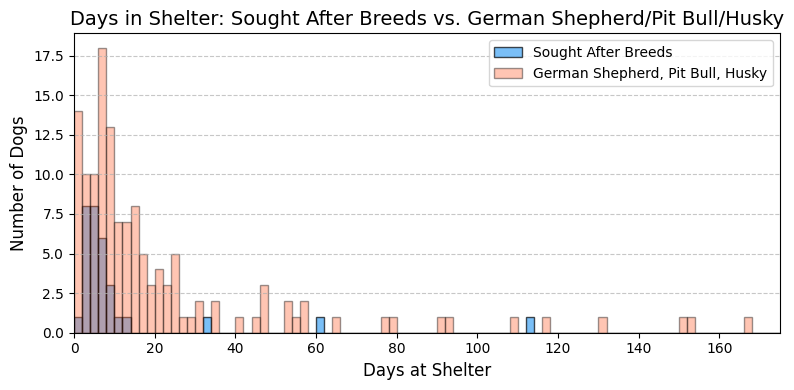

In [18]:
# Filter for Sought After Breeds
sought_after_breeds = adopted_dogs[
    adopted_dogs['Breed'].str.contains(
        r'Shih\s?Tzu|Chihuahua|Golden\s?Retriever|Rottweiler|Australian Terrier|Bully|Schipperke|Mastiff|Poodle|Pyrenees|Corso|Bulldog',
        case=False, na=False
    )
]

# Filter for German Shepherd, Pit Bull, or Husky
german_shep_pit_husky = adopted_dogs[
    adopted_dogs['Breed'].str.contains(
        r'German Shepherd|Pit Bull|Husky',
        case=False, na=False
    )
]


plt.figure(figsize=(8, 4))

# Define bins with 2-day increments
bins = range(0, int(adopted_dogs['Days_at_shelter'].max()) + 2, 2)

# Histogram for sought-after breeds
plt.hist(
    sought_after_breeds['Days_at_shelter'],
    bins=bins,
    alpha=0.7,
    label='Sought After Breeds',
    color='#42A5F5',
    edgecolor='black'
)

# Histogram for German Shepherd/Pit Bull/Husky
plt.hist(
    german_shep_pit_husky['Days_at_shelter'],
    bins=bins,
    alpha=0.4,
    label='German Shepherd, Pit Bull, Husky',
    color='#FF7043',
    edgecolor='black'
)


plt.title('Days in Shelter: Sought After Breeds vs. German Shepherd/Pit Bull/Husky', fontsize=14)
plt.xlabel('Days at Shelter', fontsize=12)
plt.ylabel('Number of Dogs', fontsize=12)
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(left=0, right= 175)
plt.tight_layout()
plt.show()

##### Sought after breeds generally see quicker adoptions rates.


##### CMACC Context: Fosters are able to provide more context & photos of the dog in a home environment as well as notes such as potty-trained, being dog-friendly or single dog only, temperment, energy level, etc. On the other hand, a lot of families come into the shelter and want to pick out a dog from the kennels.

##### Are dogs adopted more quickly from foster or from a shelter location?

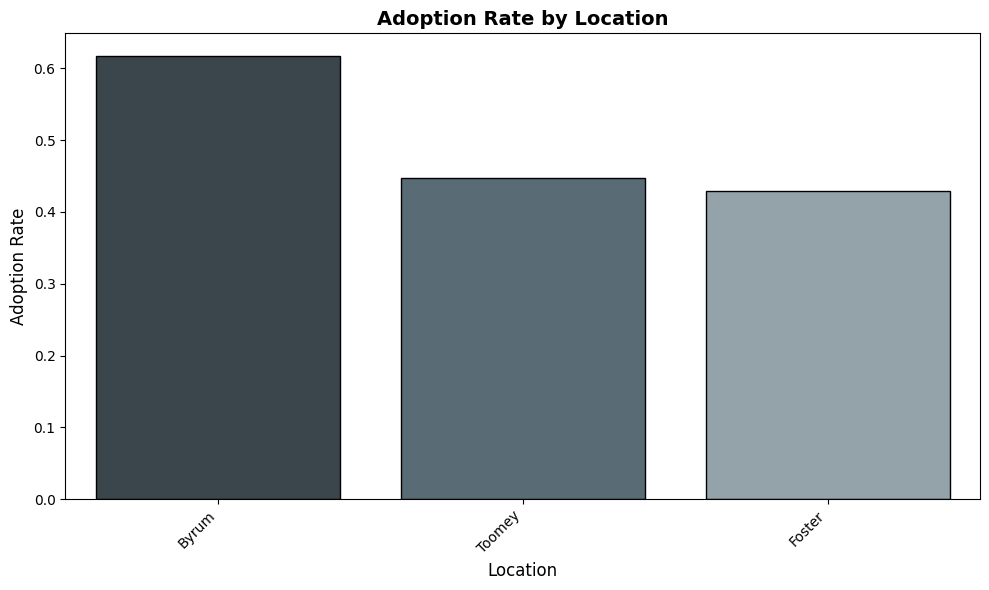

In [19]:
#Adoption Rate by Location
unique_dogs = dogs_at_shelter.sort_values('Scrape Date').drop_duplicates(subset='ID', keep='last')


location_stats = unique_dogs.groupby('location_simple').agg(
    total_dogs=('Name_ID', 'count'),
    adopted_dogs=('result', lambda x: (x == 'Adopted').astype(int).sum())
)



location_stats['adoption_rate'] = location_stats['adopted_dogs'] / location_stats['total_dogs']

location_stats = location_stats.reset_index()
location_stats = location_stats.sort_values(by='adoption_rate', ascending=False).reset_index(drop=True)

# Custom HEX color codes
custom_colors = ['#37474F', '#546E7A', '#90A4AE']

# Plot adoption rates
plt.figure(figsize=(10, 6))
sns.barplot(
    x='location_simple',
    y='adoption_rate',
    data=location_stats,
    hue = 'location_simple',
    palette=custom_colors[:len(location_stats)],
    edgecolor='black'
)

plt.title('Adoption Rate by Location', fontsize=14, fontweight='bold')
plt.xlabel('Location', fontsize=12)
plt.ylabel('Adoption Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



###### It does surprise me that Byrum has a higher adoption rate than Fosters!




####


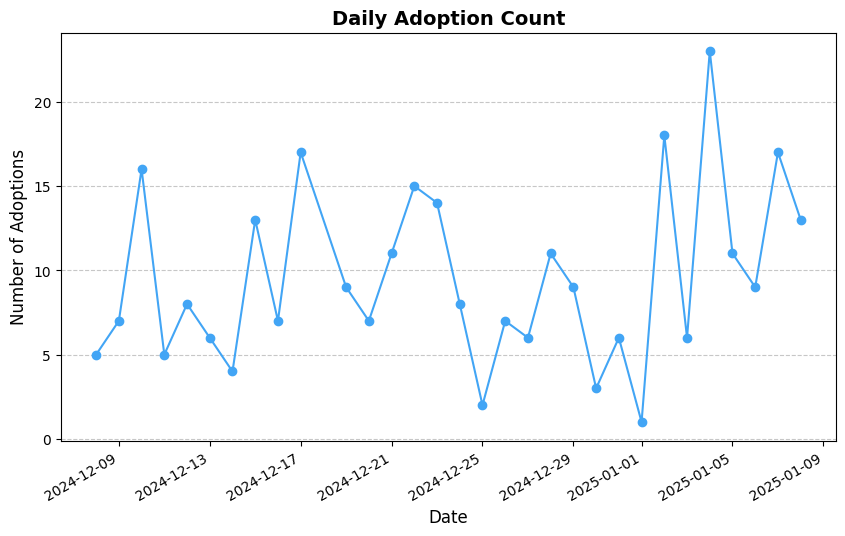

<Figure size 800x400 with 0 Axes>

In [20]:
# Adoption Count by Day

# Group by Scrape Date and count adoptions
adoption_trends = unique_dogs[unique_dogs['result'] == 'Adopted']
adoption_trends = adoption_trends.groupby('Scrape Date').size()


plt.figure(figsize=(10, 6))
adoption_trends.plot(kind='line', marker='o', color='#42A5F5')
plt.title('Daily Adoption Count', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Adoptions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.figure(figsize=(8, 4))
plt.tight_layout()
plt.show()



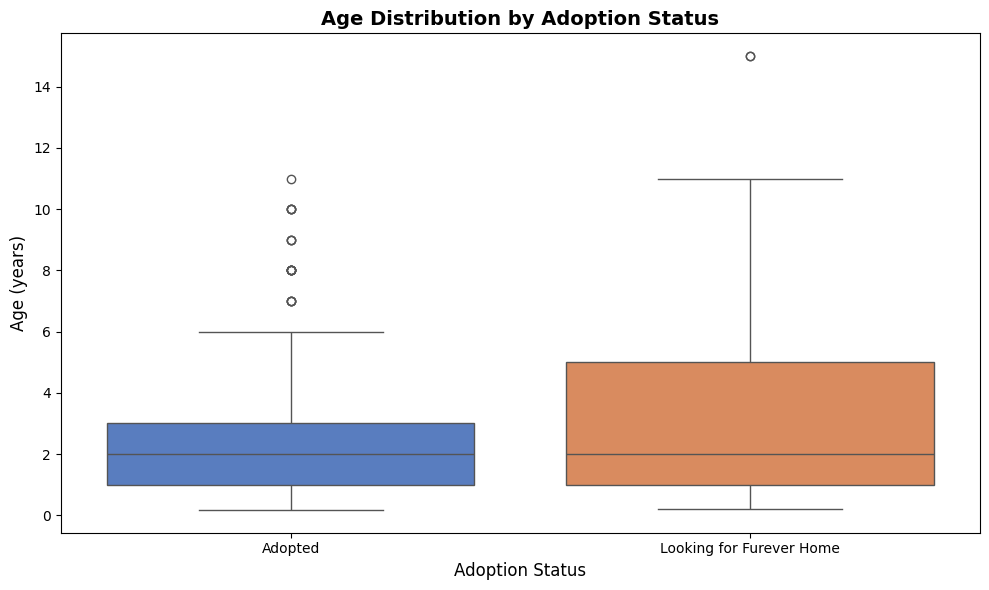

In [21]:
#Age Distribition by Adoption Status

plt.figure(figsize=(10, 6))
sns.boxplot(x='result', y='age_numeric', data=unique_dogs, palette='muted', hue='result')
plt.title('Age Distribution by Adoption Status', fontsize=14, fontweight='bold')
plt.xlabel('Adoption Status', fontsize=12)
plt.ylabel('Age (years)', fontsize=12)
plt.legend = False
plt.tight_layout()
plt.show()

###### While the median age is similar, the dogs still in need of homes has a much wider spread with more older adult dogs and senior still looking for homes.

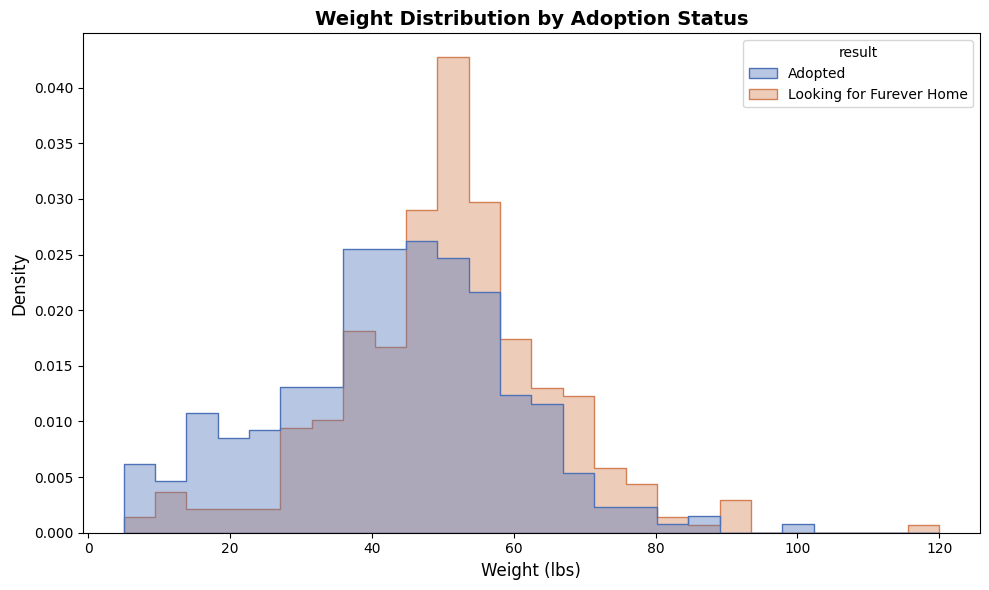

In [22]:
# Weight Distribution by Adoption Status
my_colors = {'Adopted': '#4D72B8', 'Looking for Furever Home': '#D48054'}

plt.figure(figsize=(10, 6))
sns.histplot(data=unique_dogs, x='Weight_num', hue='result', element='step', stat='density', common_norm=False, palette=my_colors, alpha=0.4)
plt.title('Weight Distribution by Adoption Status', fontsize=14, fontweight='bold')
plt.xlabel('Weight (lbs)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.tight_layout()
plt.show()

# Smaller dogs tend to see faster adoptions.

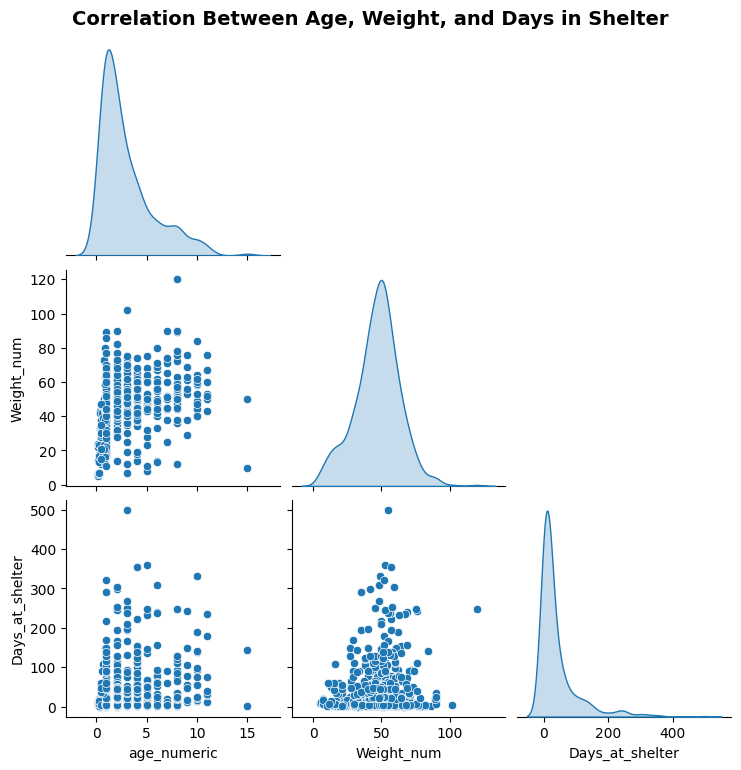

In [23]:
# Correlation Plot

sns.pairplot(unique_dogs[['age_numeric', 'Weight_num', 'Days_at_shelter']], corner=True, diag_kind='kde')
plt.suptitle('Correlation Between Age, Weight, and Days in Shelter', y=1.02, fontsize=14, fontweight='bold')
plt.show()

/var/folders/5l/7r0lrfyj4dn5flz3ntwmqs380000r6/T/ipykernel_3257/1533423651.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_stats = unique_dogs.groupby('Age Group').agg(


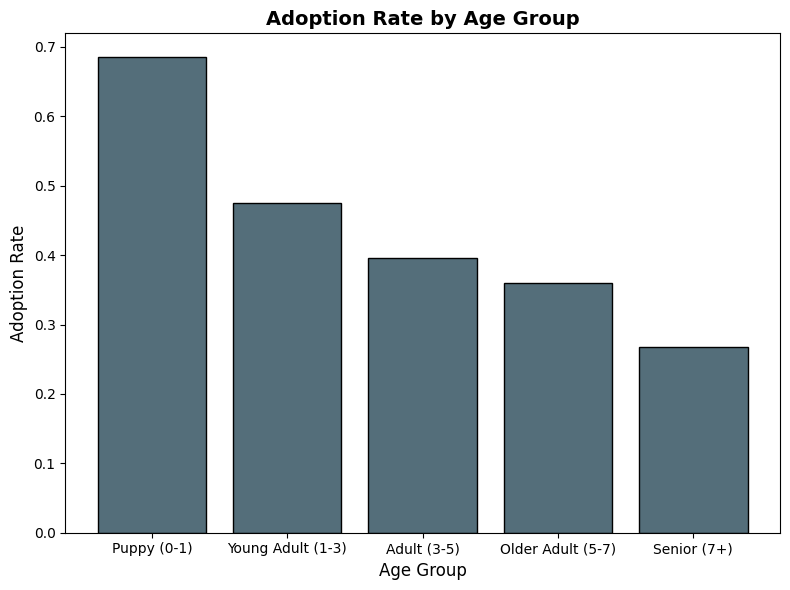

In [24]:
#Age Group vs Adoption

# Create age groups
bins = [0, 1, 3,5,7,20]  # Bins: 0-1 (Puppies), 1-7 (Adults), 7+ (Seniors)
labels = ['Puppy (0-1)', 'Young Adult (1-3)', 'Adult (3-5)' ,'Older Adult (5-7)' ,'Senior (7+)']
unique_dogs['Age Group'] = pd.cut(unique_dogs['age_numeric'], bins=bins, labels=labels, right=False)

# Calculate adoption rate by age group
age_group_stats = unique_dogs.groupby('Age Group').agg(
    total_dogs=('Name_ID', 'count'),
    adopted_dogs=('result', lambda x: (x == 'Adopted').sum())
)
age_group_stats['adoption_rate'] = age_group_stats['adopted_dogs'] / age_group_stats['total_dogs']


# Plot adoption rate by age group
plt.figure(figsize=(8, 6))
plt.bar(age_group_stats.index, age_group_stats['adoption_rate'], color='#546E7A', edgecolor='black')
plt.title('Adoption Rate by Age Group', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Adoption Rate', fontsize=12)
plt.tight_layout()
plt.show()


##### This shows a very clear trend of adoption rate decreasing with age of dog. Adopters typically lean towards younger dogs so they can enjoy more time with the dog (I mean, who can resist a puppy??) while older adults and seniors are browsed over.

/var/folders/5l/7r0lrfyj4dn5flz3ntwmqs380000r6/T/ipykernel_3257/1735659831.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_stats.index, y=gender_stats['adoption_rate'], palette='Set2', edgecolor= 'black')


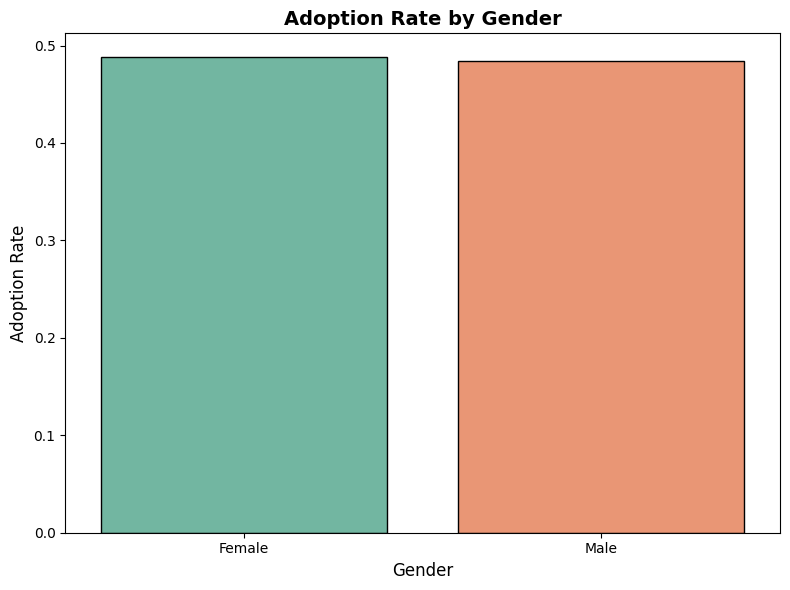

In [25]:
# Calculate adoption rate by gender

gender_stats = unique_dogs.groupby('Gender').agg(
    total_dogs=('ID', 'count'),
    adopted_dogs=('result', lambda x: (x == 'Adopted').sum())
)
gender_stats['adoption_rate'] = gender_stats['adopted_dogs'] / gender_stats['total_dogs']

# Plot adoption rates by gender
plt.figure(figsize=(8, 6))
sns.barplot(x=gender_stats.index, y=gender_stats['adoption_rate'], palette='Set2', edgecolor= 'black')
plt.title('Adoption Rate by Gender', fontsize=14, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Adoption Rate', fontsize=12)
plt.tight_layout()
plt.show()


###### Males are more common, but adoption rates are similar between genders.

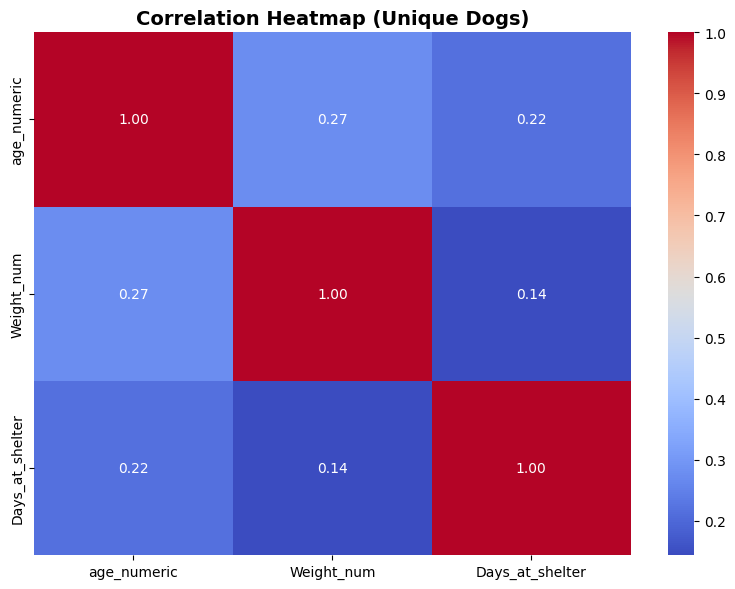

<Figure size 800x400 with 0 Axes>

In [26]:
####Correlation plot

plt.figure(figsize=(8, 6))
sns.heatmap(unique_dogs[['age_numeric', 'Weight_num', 'Days_at_shelter']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Unique Dogs)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.figure(figsize=(8, 4))
plt.show()



#### Do dogs at the front get adopted quicker? Or do potential adopters seem to walk through all the kennels?

/var/folders/5l/7r0lrfyj4dn5flz3ntwmqs380000r6/T/ipykernel_3257/752946575.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  byrum_toomey_adopted['kennel_num'] = pd.to_numeric(byrum_toomey_adopted['kennel_num'], errors='coerce')


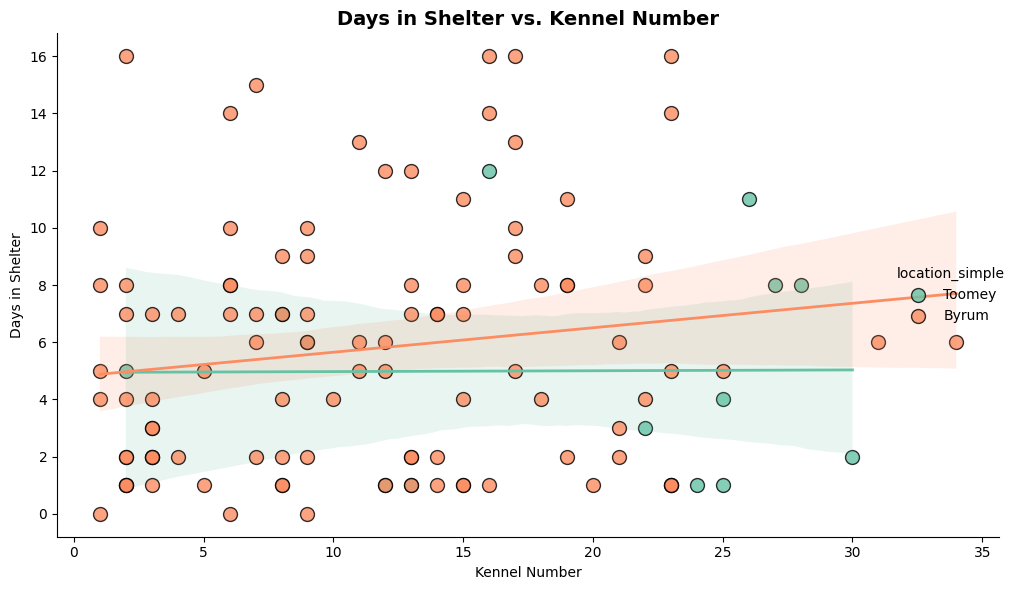

In [27]:
# Kennel Number vs. Days in Shelter
# Filter data for adopted dogs at Byrum and Toomey

byrum_toomey_adopted = unique_dogs[
    (unique_dogs['location_simple'].isin(['Byrum', 'Toomey'])) &
    (unique_dogs['result'] == 'Adopted')
]

# Convert kennel number to numeric for sorting
byrum_toomey_adopted['kennel_num'] = pd.to_numeric(byrum_toomey_adopted['kennel_num'], errors='coerce')

# Function to remove outliers based on the IQR
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Applying the function to both 'kennel_num' and 'Days_at_shelter'
byrum_toomey_adopted = remove_outliers(byrum_toomey_adopted, 'kennel_num')
byrum_toomey_adopted = remove_outliers(byrum_toomey_adopted, 'Days_at_shelter')

# Plot Kennel Number vs. Days in Shelter
sns.lmplot(
    x='kennel_num',
    y='Days_at_shelter',
    hue='location_simple',
    data=byrum_toomey_adopted,
    palette='Set2',
    height=6,
    aspect=1.5,
    scatter_kws={'s': 100, 'edgecolor': 'black'},
    line_kws={'linewidth': 2}
)

plt.title('Days in Shelter vs. Kennel Number', fontsize=14, fontweight='bold')
plt.xlabel('Kennel Number')
plt.ylabel('Days in Shelter')
plt.tight_layout()
plt.show()



##### Slightly positive trend at Byrum - Dogs that are further down the line of kennels are spending more time int he shelter before getting adopted.


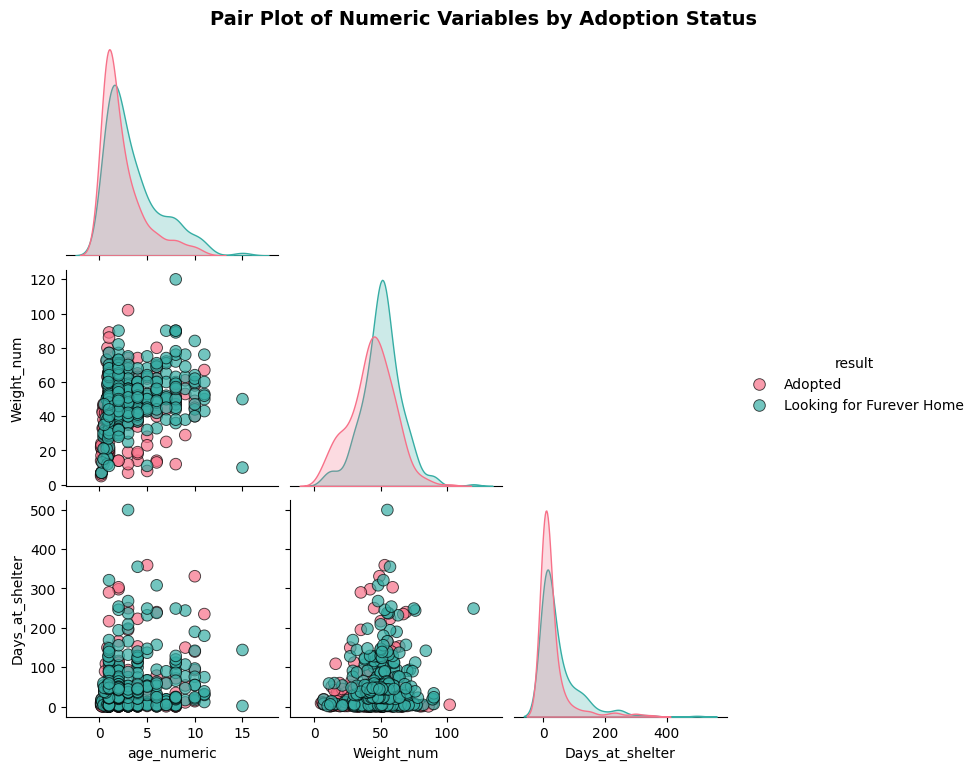

<Figure size 800x400 with 0 Axes>

In [28]:
# Pair plot for age, weight, and days in shelter
sns.pairplot(
    unique_dogs[['age_numeric', 'Weight_num', 'Days_at_shelter', 'result']],
    hue='result',
    palette='husl',
    corner=True,
    plot_kws={'alpha': 0.7, 's': 70, 'edgecolor': 'black'}
)
plt.suptitle('Pair Plot of Numeric Variables by Adoption Status', y=1.02, fontsize=14, fontweight='bold')
plt.figure(figsize=(8, 4))
plt.show()




##### Excited to collect more data and continue diving in!

## Next step: [Dashboard](https://lookerstudio.google.com/s/vONyOAuMzgg)
##### This dashboard enables volunteers to look at shelter stats and also provides a quick way to find your perfect furry friend!

